In [156]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np
import math
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')

In [157]:
filepath = 'dataset'
train_features = pd.read_csv(filepath + '/dengue_features_train.csv',
                             index_col=[0,1,2])

train_labels = pd.read_csv(filepath + '/dengue_labels_train.csv',
                           index_col=[0,1,2])

In [158]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']



In [159]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [160]:


# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)



In [161]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [162]:
print('San Juan')
print('mean: ', sj_train_labels.mean()[0])
print('var :', sj_train_labels.var()[0])

print('\nIquitos')
print('mean: ', iq_train_labels.mean()[0])
print('var :', iq_train_labels.var()[0])

San Juan
mean:  34.1805555556
var : 2640.04543969

Iquitos
mean:  7.56538461538
var : 115.895523937


In [163]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases


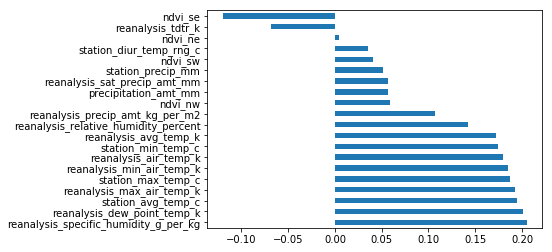

In [164]:


# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()


# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

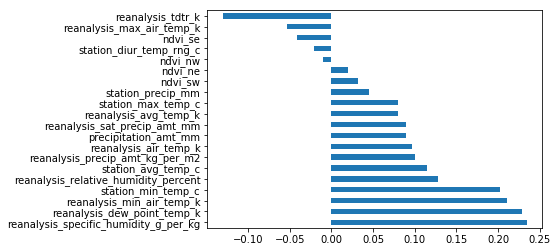

In [165]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [166]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c',
                 'reanalysis_tdtr_k']
    df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    
    return sj, iq

In [167]:
sj_train, iq_train = preprocess_data(filepath + '/dengue_features_train.csv',
                                    labels_path=filepath + "/dengue_labels_train.csv")


In [168]:
sj_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_tdtr_k,total_cases
count,936.000000,936.000000,936.000000,936.000000,936.000000,936.000000
mean,16.547535,295.104736,26.999191,22.594017,2.514667,34.180556
std,1.560663,1.570075,1.415079,1.506281,0.498182,51.381372
min,11.715714,289.642857,22.842857,17.800000,1.357143,0.000000
25%,15.233571,293.843929,25.842857,21.700000,2.157143,9.000000
50%,16.835000,295.451429,27.214286,22.800000,2.457143,19.000000
75%,17.854286,296.415714,28.175000,23.900000,2.789286,37.000000
max,19.440000,297.795714,30.071429,25.600000,4.428571,461.000000


In [169]:
iq_train.describe()

,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,station_avg_temp_c,station_min_temp_c,reanalysis_tdtr_k,total_cases
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,17.102019,295.498723,27.506331,21.210385,9.189835,7.565385
std,1.443048,1.414360,0.908973,1.257734,2.455961,10.765478
min,12.111429,290.088571,21.400000,14.700000,3.714286,0.000000
25%,16.121429,294.596429,26.957500,20.600000,7.371429,1.000000
50%,17.428571,295.852143,27.587500,21.400000,8.957143,5.000000
75%,18.180357,296.557143,28.075000,22.000000,11.003571,9.000000
max,20.461429,298.450000,30.800000,24.200000,16.028571,116.000000


In [170]:
sj_train_subtrain = sj_train.head(900)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 900)

iq_train_subtrain = iq_train.head(500)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 500)

# sj_train_subtrain = sj_train_subtrain[(np.abs(stats.zscore(sj_train_subtrain.drop(['total_cases'],axis=1))) < 5).all(axis=1)]
# iq_train_subtrain = iq_train_subtrain[(np.abs(stats.zscore(iq_train_subtrain.drop(['total_cases'],axis=1))) < 5).all(axis=1)]
# sj_train_subtest = sj_train_subtest[(np.abs(stats.zscore(sj_train_subtest.drop(['total_cases'],axis=1))) < 5).all(axis=1)]
# iq_train_subtest = iq_train_subtest[(np.abs(stats.zscore(iq_train_subtest.drop(['total_cases'],axis=1))) < 5).all(axis=1)]

# sj_train_subtrain_nt = sj_train_subtrain.drop(['total_cases'], axis=1)
# iq_train_subtrain_nt = iq_train_subtrain.drop(['total_cases'], axis=1)
# sj_train_subtest_nt = sj_train_subtest.drop(['total_cases'], axis=1)
# iq_train_subtest_nt = iq_train_subtest.drop(['total_cases'], axis=1)

# sj_train_subtrain_nt = sj_train_subtrain
# iq_train_subtrain_nt = iq_train_subtrain
# sj_train_subtest_nt = sj_train_subtest
# iq_train_subtest_nt = iq_train_subtest

# window = 4
# X_sj_train_roll = pd.rolling_mean(sj_train_subtrain_nt,window)
# sj_train_subtrain_nt = pd.concat([sj_train_subtrain_nt[:window-1],X_sj_train_roll[window-1:]],axis=0)

# X_iq_train_roll = pd.rolling_mean(iq_train_subtrain_nt,window)
# iq_train_subtrain_nt = pd.concat([iq_train_subtrain_nt[:window-1],X_iq_train_roll[window-1:]],axis=0)

# X_sj_test_roll = pd.rolling_mean(sj_train_subtest_nt,window)
# sj_train_subtest_nt = pd.concat([sj_train_subtest_nt[:window-1],X_sj_test_roll[window-1:]],axis=0)

# X_iq_test_roll = pd.rolling_mean(iq_train_subtest_nt,window)
# iq_train_subtest_nt = pd.concat([iq_train_subtest_nt[:window-1],X_iq_test_roll[window-1:]],axis=0)

# sj_train_subtrain = pd.concat([sj_train_subtrain_nt,sj_train_subtrain['total_cases']],axis=1)
# iq_train_subtrain = pd.concat([iq_train_subtrain_nt,iq_train_subtrain['total_cases']],axis=1)

# sj_train_subtest = pd.concat([sj_train_subtest_nt,sj_train_subtest['total_cases']],axis=1)
# iq_train_subtest = pd.concat([iq_train_subtest_nt,iq_train_subtest['total_cases']],axis=1)

# sj_train_subtrain = sj_train_subtrain_nt
# iq_train_subtrain = iq_train_subtrain_nt
# sj_train_subtest = sj_train_subtest_nt
# iq_train_subtest = iq_train_subtest_nt

In [171]:
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    "reanalysis_specific_humidity_g_per_kg + " \
                    "reanalysis_dew_point_temp_k + " \
                    "station_min_temp_c + " \
                    "station_avg_temp_c + " \
                    "reanalysis_tdtr_k"
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula,
                        data=train,
                        family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)


best alpha =  1e-08
best score =  28.6597222222
best alpha =  1e-08
best score =  6.1


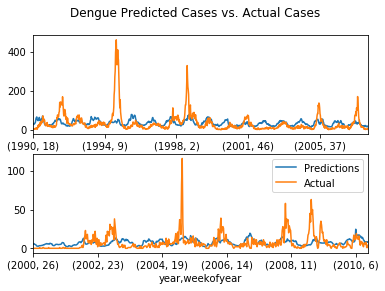

In [172]:
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_train['fitted'] = sj_best_model.fittedvalues
sj_train.fitted.plot(ax=axes[0], label="Predictions")
sj_train.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq_train['fitted'] = iq_best_model.fittedvalues
iq_train.fitted.plot(ax=axes[1], label="Predictions")
iq_train.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()


In [173]:
sj_test, iq_test = preprocess_data(filepath + '/dengue_features_test.csv')

sj_predictions = sj_best_model.predict(sj_test).astype(int)
iq_predictions = iq_best_model.predict(iq_test).astype(int)

submission = pd.read_csv(filepath + "/submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv(filepath + "/benchmark_5_salaka.csv")
